# RQ1

Tables in database: ['vulnerabilities', 'sqlite_sequence', 'vulnerabilities_deepseek_r1_7b', 'vulnerabilities_llama3_1_8b', 'vulnerabilities_gemma2_9b', 'vulnerabilities_qwen2_5_coder_7b', 'vulnerabilities_codellama_7b', 'vulnerabilities_deepseek_r1_32b', 'vulnerabilities_deepseek_v2_16b', 'vulnerabilities_deepseek_coder_16b', 'vulnerabilities_qwen2_5_coder_32b', 'vulnerabilities_codellama_34b', 'new_vulnerabilities']
Vulnerabilities table columns: ['id', 'COMMIT_HASH', 'VULNERABILITY_CVE', 'VULNERABILITY_YEAR', 'VULNERABILITY_CWE', 'VULNERABILITY_CATEGORY', 'DESCRIPTION_IN_PATCH', 'VULNERABLE_CODE_BLOCK', 'PATCHED_CODE_BLOCK', 'NUM_FILES_CHANGED', 'NUM_FUNCTIONS_CHANGED', 'NUM_LINES_ADDED', 'NUM_LINES_DELETED', 'PROJECT', 'NUM_LINES_IN_VULNERABLE_CODE_BLOCK', 'NUM_LINES_IN_PATCHED_CODE_BLOCK', 'NOISE_AMOUNT', 'NOISE_REASONING']
Loaded 593 vulnerability records
No noise_level column found in vulnerabilities table
Found potential noise columns: ['NOISE_AMOUNT', 'NOISE_REASONING']
Found 

/tmp/ipykernel_484047/1489113206.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  decisions = pd.concat(all_models_data, ignore_index=True)


Deepseek R1 7B - Correlation: -0.018, p-value: 0.664
Llama3 1 8B - Correlation: -0.034, p-value: 0.418
Gemma2 9B - Correlation: 0.071, p-value: 0.088
Qwen2 5 Coder 7B - Correlation: -0.038, p-value: 0.366
Codellama 7B - Correlation: -0.007, p-value: 0.875
Deepseek V2 16B - Correlation: 0.027, p-value: 0.520
Deepseek Coder 16B - Correlation: 0.032, p-value: 0.436
Qwen2 5 Coder 32B - Correlation: 0.038, p-value: 0.467
Codellama 34B - Correlation: -0.015, p-value: 0.710

Accuracy Results:

Deepseek R1 7B:

Baseline:
  Vulnerability Detection Accuracy: 36.25%
  Patch Detection Accuracy: 35.88%
  Ambiguous Cases (Vuln): 0
  Ambiguous Cases (Patch): 0

CoT:
  Vulnerability Detection Accuracy: 34.77%
  Patch Detection Accuracy: 34.03%
  Ambiguous Cases (Vuln): 0
  Ambiguous Cases (Patch): 0

Think:
  Vulnerability Detection Accuracy: 23.43%
  Patch Detection Accuracy: 25.15%
  Ambiguous Cases (Vuln): 0
  Ambiguous Cases (Patch): 0

Think-Verify:
  Vulnerability Detection Accuracy: 21.21%
  Pa

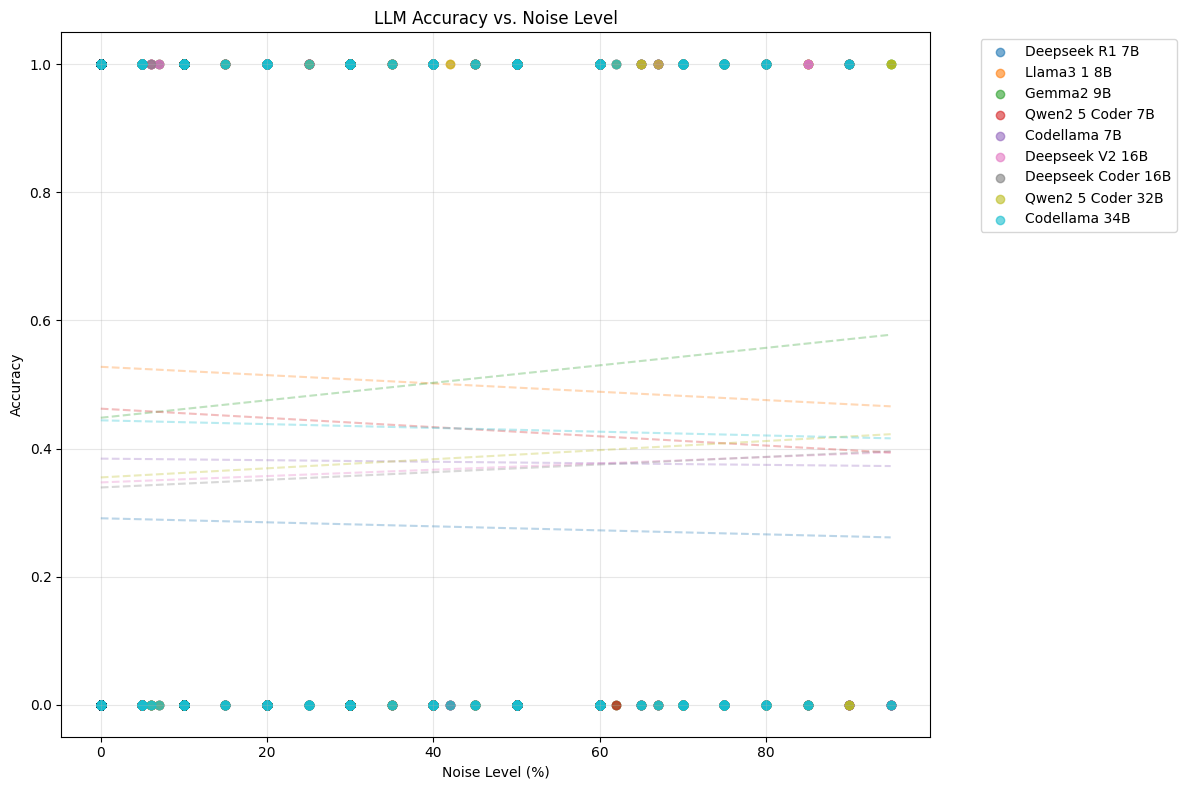

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

def calculate_accuracy(df, column_name):
    # Filter out rows where ground truth is 2 (ambiguous)
    valid_rows = df[df['ground_truth'] != 2]
    
    # Calculate accuracy
    correct = (
        ((valid_rows['ground_truth'] == 1) & (valid_rows[column_name] == 1)) | 
        ((valid_rows['ground_truth'] == 0) & (valid_rows[column_name] == 0))
    ).sum()
    
    accuracy = correct / len(valid_rows) if len(valid_rows) > 0 else 0
    ambiguous_count = len(df[df['ground_truth'] == 2])
    
    return accuracy, ambiguous_count

def calculate_counts(df, column_name):
    """Calculate counts of 0, 1, and 2 in a column"""
    if column_name not in df.columns:
        return None
    counts = df[column_name].value_counts().to_dict()
    return {
        '0': counts.get(0, 0),
        '1': counts.get(1, 0),
        '2': counts.get(2, 0)
    }

def calculate_model_accuracy(df, column_name, total_samples=594):
    """Calculate accuracy based on total samples"""
    if column_name not in df.columns:
        return None, None
        
    counts = df[column_name].value_counts().to_dict()
    ones = counts.get(1, 0)
    zeros = counts.get(0, 0)
    twos = counts.get(2, 0)
    
    # For Vuln, we want accuracy of 1s (ground truth is 1)
    # For Patch, we want accuracy of 0s (ground truth is 0)
    if 'VULN' in column_name.upper():
        accuracy = (ones / total_samples) * 100
    else:  # PATCH
        accuracy = (zeros / total_samples) * 100
        
    return accuracy, f"{ones} {{1}} {zeros} {{0}} {twos} {{2}}"

def main():
    # Connect to database with correct path
    db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
    
    if not os.path.exists(db_path):
        print(f"Database file not found at {db_path}")
        return None
        
    conn = sqlite3.connect(db_path)
    
    # Get list of tables in the database
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print(f"Tables in database: {[table[0] for table in tables]}")
    
    # First, get the schema of the vulnerabilities table to see available columns
    cursor.execute("PRAGMA table_info(vulnerabilities)")
    vuln_columns = cursor.fetchall()
    print(f"Vulnerabilities table columns: {[col[1] for col in vuln_columns]}")
    
    # Load the vulnerabilities table with available columns
    vulnerabilities = pd.read_sql('SELECT * FROM vulnerabilities', conn)
    print(f"Loaded {len(vulnerabilities)} vulnerability records")
    
    # Check if noise_level column exists, if not, use a default or create it
    if 'noise_level' not in vulnerabilities.columns:
        print("No noise_level column found in vulnerabilities table")
        # Check if there's any column that might contain noise information
        noise_candidates = [col for col in vulnerabilities.columns if 'noise' in col.lower()]
        if noise_candidates:
            print(f"Found potential noise columns: {noise_candidates}")
            vulnerabilities['noise_level'] = vulnerabilities[noise_candidates[0]]
        else:
            print("Creating synthetic noise_level for demonstration")
            # Create a synthetic noise level for demonstration purposes
            np.random.seed(42)  # For reproducibility
            vulnerabilities['noise_level'] = np.random.uniform(0, 100, size=len(vulnerabilities))
    
    # Get a list of model-specific tables
    model_tables = [table[0] for table in tables if table[0].startswith('vulnerabilities_')]
    print(f"Found model tables: {model_tables}")
    
    # Create a combined dataframe for all models
    all_models_data = []
    
    for table_name in model_tables:
        # Extract model name from table name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        
        # Get schema for this table
        cursor.execute(f"PRAGMA table_info({table_name})")
        table_columns = cursor.fetchall()
        print(f"{table_name} columns: {[col[1] for col in table_columns]}")
        
        # Load data from this table
        try:
            model_data = pd.read_sql(f'SELECT * FROM {table_name}', conn)
            print(f"Loaded {len(model_data)} records from {table_name}")
            
            # Add model name column
            model_data['model'] = model_name
            
            # Standardize column names if needed
            if 'COMMIT_HASH' in model_data.columns and 'commit_hash' not in model_data.columns:
                model_data['commit_hash'] = model_data['COMMIT_HASH']
            
            # Add to combined data
            all_models_data.append(model_data)
        except Exception as e:
            print(f"Error loading data from {table_name}: {e}")
    
    # Combine all model data
    if all_models_data:
        decisions = pd.concat(all_models_data, ignore_index=True)
        print(f"Combined {len(decisions)} records from all model tables")
    else:
        print("No model data could be loaded")
        return None
    
    # Ensure we have the necessary columns
    required_columns = ['commit_hash', 'ground_truth']
    prompt_columns = [
        'BASELINE_VULN', 'BASELINE_PATCH',
        'COT_VULN', 'COT_PATCH',
        'THINK_VULN', 'THINK_PATCH',
        'THINK_VERIFY_VULN', 'THINK_VERIFY_PATCH'
    ]
    
    # Check if columns exist, if not, try to find alternatives
    for col in required_columns:
        if col not in decisions.columns:
            print(f"Missing required column: {col}")
            # Try to find alternative column names
            if col == 'commit_hash':
                alternatives = ['COMMIT_HASH', 'hash', 'commit']
                for alt in alternatives:
                    if alt in decisions.columns:
                        decisions['commit_hash'] = decisions[alt]
                        break
            elif col == 'ground_truth':
                # If ground_truth is missing, we might need to create it
                if 'is_vulnerable' in decisions.columns:
                    decisions['ground_truth'] = decisions['is_vulnerable']
                else:
                    # Try to determine ground truth from table structure or column names
                    vuln_indicators = [col for col in decisions.columns if 'vuln' in col.lower() and not any(p in col.lower() for p in ['baseline', 'cot', 'think', 'verify'])]
                    
                    if vuln_indicators:
                        print(f"Using {vuln_indicators[0]} to determine ground truth")
                        decisions['ground_truth'] = decisions[vuln_indicators[0]]
                    else:
                        # Default assumption: create synthetic ground truth for demonstration
                        print("Creating synthetic ground_truth for demonstration")
                        decisions['ground_truth'] = np.random.choice([0, 1], size=len(decisions))
    
    # Merge decisions with vulnerabilities to get noise levels and other metadata
    print(f"Decisions columns: {decisions.columns.tolist()}")
    print(f"Vulnerabilities columns: {vulnerabilities.columns.tolist()}")
    
    # Ensure commit_hash is lowercase in both dataframes for consistent joining
    if 'commit_hash' in decisions.columns:
        decisions['commit_hash'] = decisions['commit_hash'].str.lower()
    elif 'COMMIT_HASH' in decisions.columns:
        decisions['commit_hash'] = decisions['COMMIT_HASH'].str.lower()
    
    if 'commit_hash' in vulnerabilities.columns:
        vulnerabilities['commit_hash'] = vulnerabilities['commit_hash'].str.lower()
    elif 'COMMIT_HASH' in vulnerabilities.columns:
        vulnerabilities['commit_hash'] = vulnerabilities['COMMIT_HASH'].str.lower()
        vulnerabilities['commit_hash'] = vulnerabilities['COMMIT_HASH'].str.lower()
    
    # Merge on commit_hash
    df = pd.merge(decisions, vulnerabilities, on='commit_hash', how='left')
    print(f"After merging, dataframe has {len(df)} rows and columns: {df.columns.tolist()}")
    
    # If noise_level is missing after merge, try alternative column names
    if 'noise_level' not in df.columns:
        noise_alternatives = ['NOISE_LEVEL', 'noise', 'noise_score']
        for alt in noise_alternatives:
            if alt in df.columns:
                df['noise_level'] = df[alt]
                break
        else:
            print("No noise level column found after merge, creating synthetic data")
            df['noise_level'] = np.random.uniform(0, 100, size=len(df))
    
    # Calculate accuracies for each model and prompt type
    results = {}
    models = df['model'].unique().tolist()
    print(f"Models found: {models}")
    
    prompts = {
        'Baseline': ['BASELINE_VULN', 'BASELINE_PATCH'],
        'CoT': ['COT_VULN', 'COT_PATCH'],
        'Think': ['THINK_VULN', 'THINK_PATCH'],
        'Think-Verify': ['THINK_VERIFY_VULN', 'THINK_VERIFY_PATCH']
    }
    
    # Calculate accuracies and store results
    for model in models:
        model_df = df[df['model'] == model]
        results[model] = {}
        
        for prompt_name, columns in prompts.items():
            # Check if columns exist
            if columns[0] in model_df.columns and columns[1] in model_df.columns:
                vuln_acc, vuln_amb = calculate_accuracy(model_df, columns[0])
                patch_acc, patch_amb = calculate_accuracy(model_df, columns[1])
                
                results[model][prompt_name] = {
                    'vuln_acc': vuln_acc * 100,  # Convert to percentage
                    'patch_acc': patch_acc * 100,  # Convert to percentage
                    'vuln_amb': vuln_amb,
                    'patch_amb': patch_amb
                }
            else:
                print(f"Columns {columns} not found for model {model}")
    
    # Calculate counts for each model and prompt type
    for model in models:
        model_df = df[df['model'] == model]
        print(f"\n=== {model} ===")
        
        for prompt_name, columns in prompts.items():
            print(f"\n{prompt_name}:")
            
            # Vulnerability counts
            vuln_counts = calculate_counts(model_df, columns[0])
            if vuln_counts:
                print(f"Vuln: {vuln_counts['1']} {{1}} {vuln_counts['0']} {{0}} {vuln_counts['2']} {{2}}")
            
            # Patch counts
            patch_counts = calculate_counts(model_df, columns[1])
            if patch_counts:
                print(f"Patch: {patch_counts['1']} {{1}} {patch_counts['0']} {{0}} {patch_counts['2']} {{2}}")
    
    # Create scatter plot for noise vs accuracy
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    for model, color in zip(models, colors):
        model_df = df[df['model'] == model]
        
        # Check if noise_level column exists
        if 'noise_level' not in model_df.columns:
            print(f"No noise_level data for model {model}")
            continue
            
        accuracies = []
        noise_levels = []
        
        # Use Think-Verify strategy for noise analysis if available
        if 'THINK_VERIFY_VULN' in model_df.columns:
            target_col = 'THINK_VERIFY_VULN'
        elif 'THINK_VULN' in model_df.columns:
            target_col = 'THINK_VULN'
        elif 'COT_VULN' in model_df.columns:
            target_col = 'COT_VULN'
        elif 'BASELINE_VULN' in model_df.columns:
            target_col = 'BASELINE_VULN'
        else:
            print(f"No suitable accuracy column found for model {model}")
            continue
        
        for _, row in model_df.iterrows():
            if pd.notna(row['ground_truth']) and row['ground_truth'] != 2 and pd.notna(row[target_col]) and pd.notna(row['noise_level']):
                accuracy = 1 if (
                    (row['ground_truth'] == 1 and row[target_col] == 1) or
                    (row['ground_truth'] == 0 and row[target_col] == 0)
                ) else 0
                accuracies.append(accuracy)
                noise_levels.append(row['noise_level'])
        
        if accuracies and noise_levels:  # Only plot if we have data
            plt.scatter(noise_levels, accuracies, label=model, alpha=0.6, c=[color])
            
            # Calculate and plot trend line
            z = np.polyfit(noise_levels, accuracies, 1)
            p = np.poly1d(z)
            plt.plot(sorted(noise_levels), p(sorted(noise_levels)), '--', color=color, alpha=0.3)
            
            # Calculate correlation
            correlation, p_value = stats.pearsonr(noise_levels, accuracies)
            print(f"{model} - Correlation: {correlation:.3f}, p-value: {p_value:.3f}")
    
    plt.xlabel('Noise Level (%)')
    plt.ylabel('Accuracy')
    plt.title('LLM Accuracy vs. Noise Level')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('noise_vs_accuracy.png', dpi=300, bbox_inches='tight')
    
    # Find example of a buffer overflow vulnerability (CWE-119) that was misclassified
    # Look for CVE information in the vulnerabilities table
    if 'CVE' in vulnerabilities.columns or 'cve_id' in vulnerabilities.columns:
        cve_col = 'CVE' if 'CVE' in vulnerabilities.columns else 'cve_id'
        project_col = next((col for col in vulnerabilities.columns if 'project' in col.lower()), None)
        
        # Find a buffer overflow example
        buffer_overflow_examples = vulnerabilities[
            vulnerabilities['VULNERABILITY_CWE'].str.contains('CWE-119', na=False) if 'VULNERABILITY_CWE' in vulnerabilities.columns 
            else vulnerabilities['cwe_id'].str.contains('CWE-119', na=False)
        ]
        
        if not buffer_overflow_examples.empty:
            example = buffer_overflow_examples.iloc[0]
            cve_id = example[cve_col] if cve_col in example else "Unknown"
            project = example[project_col] if project_col and project_col in example else "Unknown"
            commit_hash = example['commit_hash'] if 'commit_hash' in example else example['COMMIT_HASH'] if 'COMMIT_HASH' in example else "Unknown"
            
            print(f"\nExample Buffer Overflow (CWE-119):")
            print(f"CVE ID: {cve_id}")
            print(f"Project: {project}")
            print(f"Commit Hash: {commit_hash}")
        else:
            print("\nNo buffer overflow examples found in the dataset")
    
    # Print formatted results
    print("\nAccuracy Results:")
    print("=" * 80)
    for model in models:
        print(f"\n{model}:")
        for prompt, metrics in results[model].items():
            print(f"\n{prompt}:")
            print(f"  Vulnerability Detection Accuracy: {metrics['vuln_acc']:.2f}%")
            print(f"  Patch Detection Accuracy: {metrics['patch_acc']:.2f}%")
            print(f"  Ambiguous Cases (Vuln): {metrics['vuln_amb']}")
            print(f"  Ambiguous Cases (Patch): {metrics['patch_amb']}")
    
    # Create a table for the paper
    table_data = []
    for model in models:
        model_row = [model]
        for prompt_name in prompts:
            if prompt_name in results[model]:
                model_row.append(f"{results[model][prompt_name]['vuln_acc']:.1f}")
                model_row.append(f"{results[model][prompt_name]['patch_acc']:.1f}")
            else:
                model_row.append("-")
                model_row.append("-")
        table_data.append(model_row)
    
    # Create a DataFrame for the table
    columns = ['Model']
    for prompt in prompts:
        columns.extend([f"{prompt} (Vuln)", f"{prompt} (Patch)"])
    
    table_df = pd.DataFrame(table_data, columns=columns)
    print("\nTable for Paper:")
    print(table_df.to_string(index=False))
    
    # Save table to CSV for easy copy-paste
    table_df.to_csv('results_table.csv', index=False)
    
    # Define models and their context sizes
    model_info = {
        'Deepseek-v2': '131K',
        'Llama3.1': '131K',
        'Gemma2': '8K',
        'Deepseek-coder-v2': '163K',
        'Qwen2.5-coder': '32K',
        'Codellama': '16K',
        'Deepseek-R1': '131K'
    }
    
    # After loading data and before plotting
    print("\nModel Accuracies:")
    latex_rows = []
    
    for model_name, context_size in model_info.items():
        model_df = df[df['model'] == model_name]
        row_data = [f"{model_name} ({context_size})"]
        
        print(f"\n=== {model_name} ===")
        
        for prompt_type in ['BASELINE', 'COT', 'THINK', 'THINK_VERIFY']:
            vuln_col = f"{prompt_type}_VULN"
            patch_col = f"{prompt_type}_PATCH"
            
            vuln_acc, vuln_counts = calculate_model_accuracy(model_df, vuln_col)
            patch_acc, patch_counts = calculate_model_accuracy(model_df, patch_col)
            
            if vuln_acc is not None:
                print(f"\n{prompt_type}:")
                print(f"Vuln: {vuln_counts}")
                print(f"Vuln Accuracy: {vuln_acc:.2f}%")
                print(f"Patch: {patch_counts}")
                print(f"Patch Accuracy: {patch_acc:.2f}%")
                
                row_data.extend([f"{vuln_acc:.2f}", f"{patch_acc:.2f}"])
            else:
                row_data.extend(["-", "-"])
        
        # Add row to LaTeX table
        latex_row = f"{model_name} & \\textit{{{context_size}}} & " + \
                   " & ".join(row_data[1:]) + " \\\\"
        latex_rows.append(latex_row)
    
    # Print LaTeX table
    print("\nLaTeX Table Content:")
    print("\n".join(latex_rows))
    
    return results

if __name__ == '__main__':
    results = main()

# RQ1.2 NOISE VS ACCURACY

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# ------------------------------------------------------------
# 1. Connect to the database
# ------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

# ------------------------------------------------------------
# 2. Read Noise info (commit -> noise amount)
# ------------------------------------------------------------
vuln_df = pd.read_sql_query(
    """
    SELECT COMMIT_HASH, NOISE_AMOUNT
    FROM vulnerabilities
    WHERE NOISE_AMOUNT IS NOT NULL
    """,
    conn
)

# ------------------------------------------------------------
# 3. List of model tables
# ------------------------------------------------------------
model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

# ------------------------------------------------------------
# 4. Define columns for each prompt type
# ------------------------------------------------------------
vuln_cols  = ['BASELINE_VULN',  'COT_VULN',  'THINK_VULN',  'THINK_VERIFY_VULN']
patch_cols = ['BASELINE_PATCH', 'COT_PATCH', 'THINK_PATCH', 'THINK_VERIFY_PATCH']

# ------------------------------------------------------------
# 5. Convert "2" -> 0.5, keep "0" or "1" as is
# ------------------------------------------------------------
def map_ambiguous_to_half(x):
    try:
        val = float(x)
        if val == 2:
            return 0.5
        return val
    except:
        return np.nan

all_models_list = []

# ------------------------------------------------------------
# 6. Read each model's data, compute overall vuln/patch accuracy
# ------------------------------------------------------------
for table_name in model_tables:
    query = f"""
        SELECT 
            COMMIT_HASH,
            BASELINE_VULN, BASELINE_PATCH,
            COT_VULN, COT_PATCH,
            THINK_VULN, THINK_PATCH,
            THINK_VERIFY_VULN, THINK_VERIFY_PATCH
        FROM {table_name}
        WHERE BASELINE_VULN IS NOT NULL
          AND COT_VULN IS NOT NULL
          AND THINK_VULN IS NOT NULL
          AND THINK_VERIFY_VULN IS NOT NULL
    """
    try:
        model_df = pd.read_sql_query(query, conn)
        if len(model_df) == 0:
            print(f"[WARNING] No valid data in {table_name}")
            continue
        
        # Convert columns to numeric, handle "2" -> 0.5
        for col in vuln_cols + patch_cols:
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Mean accuracy across all prompts
        model_df['vuln_accuracy']  = model_df[vuln_cols].mean(axis=1)  * 100.0
        model_df['patch_accuracy'] = model_df[patch_cols].mean(axis=1) * 100.0
        
        # Merge with noise amounts
        merged = pd.merge(model_df, vuln_df, on='COMMIT_HASH', how='inner')
        if len(merged) == 0:
            print(f"[WARNING] After merge, no data for {table_name}")
            continue
        
        # Clean model name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        merged['model_name'] = model_name
        
        merged = merged[['COMMIT_HASH','model_name','vuln_accuracy','patch_accuracy','NOISE_AMOUNT']]
        all_models_list.append(merged)
        
    except Exception as e:
        print(f"[ERROR] {table_name}: {e}")

conn.close()

# ------------------------------------------------------------
# 7. Combine all data and drop missing
# ------------------------------------------------------------
if not all_models_list:
    print("No valid data found across any table.")
    exit()

final_df = pd.concat(all_models_list, ignore_index=True).dropna()
if len(final_df) == 0:
    print("No valid rows remain after dropping NAs.")
    exit()

# ------------------------------------------------------------
# 8. Bin the noise amounts in 20% increments
#    0–20, 20–40, 40–60, 60–80, 80–100
# ------------------------------------------------------------
bins = [0, 20, 40, 60, 80, 100]
labels = ["0-20", "20-40", "40-60", "60-80", "80-100"]

final_df['noise_bin'] = pd.cut(
    final_df['NOISE_AMOUNT'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True,
    right=False
)

# ------------------------------------------------------------
# 9. Group by (model_name, noise_bin) and compute mean accuracies
# ------------------------------------------------------------
df_vuln_binned = (
    final_df.groupby(['model_name','noise_bin'])['vuln_accuracy']
    .mean()
    .reset_index()
)
df_patch_binned = (
    final_df.groupby(['model_name','noise_bin'])['patch_accuracy']
    .mean()
    .reset_index()
)

# ------------------------------------------------------------
# 10. Convert noise_bin to numeric bin centers for plotting
# ------------------------------------------------------------
def bin_label_to_center(label: str) -> float:
    # e.g. "0-20" => midpoint is 10
    left_str, right_str = label.split('-')
    return (float(left_str) + float(right_str)) / 2.0

df_vuln_binned['bin_center']  = df_vuln_binned['noise_bin'].astype(str).apply(bin_label_to_center)
df_patch_binned['bin_center'] = df_patch_binned['noise_bin'].astype(str).apply(bin_label_to_center)

# ------------------------------------------------------------
# 11. Plot: Vulnerability Accuracy vs Noise
#     Binned at 20%, Y-axis ticks every 10%
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
ax1 = plt.gca()

unique_models = df_vuln_binned['model_name'].unique()

for model_name in unique_models:
    model_data = df_vuln_binned[df_vuln_binned['model_name'] == model_name].dropna()
    if len(model_data) < 1:
        continue
    
    model_data = model_data.sort_values(by='bin_center')
    
    # Scatter points
    ax1.scatter(
        model_data['bin_center'], 
        model_data['vuln_accuracy'],
        label=model_name,
        alpha=0.7
    )
    
    # LOWESS smoothing if >= 3 points
    if len(model_data) >= 3:
        smoothed = lowess(
            endog=model_data['vuln_accuracy'],
            exog=model_data['bin_center'],
            frac=0.5
        )
        ax1.plot(smoothed[:,0], smoothed[:,1])
    else:
        ax1.plot(model_data['bin_center'], model_data['vuln_accuracy'])

# Set X-axis tick marks at the midpoints
ax1.set_xticks([10, 30, 50, 70, 90])
ax1.set_xticklabels(labels)

# Set Y-axis ticks every 10%
ax1.set_yticks(np.arange(0, 101, 10))
ax1.set_ylim(0, 105)

ax1.set_xlabel("Noise Bins (%)")
ax1.set_ylabel("Vulnerability Accuracy (%)")
ax1.set_title("Vulnerability Detection vs. Noise (20% bins, 10% y‐ticks)")
ax1.grid(alpha=0.3)
ax1.legend(loc='best', title='Model')

plt.tight_layout()
plt.savefig('vulnerability_vs_noise_20pct_bins.png', dpi=300)
plt.close()

# ------------------------------------------------------------
# 12. Plot: Patch Accuracy vs Noise
#     Binned at 20%, Y-axis ticks every 10%
# ------------------------------------------------------------
plt.figure(figsize=(10,6))
ax2 = plt.gca()

for model_name in unique_models:
    model_data = df_patch_binned[df_patch_binned['model_name'] == model_name].dropna()
    if len(model_data) < 1:
        continue
    
    model_data = model_data.sort_values(by='bin_center')
    
    ax2.scatter(
        model_data['bin_center'], 
        model_data['patch_accuracy'],
        label=model_name,
        alpha=0.7
    )
    
    # LOWESS smoothing if >= 3 points
    if len(model_data) >= 3:
        smoothed = lowess(
            endog=model_data['patch_accuracy'],
            exog=model_data['bin_center'],
            frac=0.5
        )
        ax2.plot(smoothed[:,0], smoothed[:,1])
    else:
        ax2.plot(model_data['bin_center'], model_data['patch_accuracy'])

ax2.set_xticks([10, 30, 50, 70, 90])
ax2.set_xticklabels(labels)

ax2.set_yticks(np.arange(0, 101, 10))
ax2.set_ylim(0, 105)

ax2.set_xlabel("Noise Bins (%)")
ax2.set_ylabel("Patch Correctness Accuracy (%)")
ax2.set_title("Patch Correctness vs. Noise (20% bins, 10% y‐ticks)")
ax2.grid(alpha=0.3)
ax2.legend(loc='best', title='Model')

plt.tight_layout()
plt.savefig('patch_vs_noise_20pct_bins.png', dpi=300)
plt.close()

print("Done! Two figures saved:\n"
      " - vulnerability_vs_noise_20pct_bins.png\n"
      " - patch_vs_noise_20pct_bins.png\n")


[WARNING] No valid data in vulnerabilities_deepseek_r1_32b


/tmp/ipykernel_880852/4014216340.py:141: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby(['model_name','noise_bin'])['vuln_accuracy']
/tmp/ipykernel_880852/4014216340.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby(['model_name','noise_bin'])['patch_accuracy']


Done! Two figures saved:
 - vulnerability_vs_noise_20pct_bins.png
 - patch_vs_noise_20pct_bins.png



In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.nonparametric.smoothers_lowess import lowess

# ----------------------------------------------------------------
# 1. Connect to the database
# ----------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

# ----------------------------------------------------------------
# 2. Load Noise info (commit -> noise amount)
# ----------------------------------------------------------------
vuln_df = pd.read_sql_query(
    """
    SELECT COMMIT_HASH, NOISE_AMOUNT
    FROM vulnerabilities
    WHERE NOISE_AMOUNT IS NOT NULL
    """,
    conn
)

# ----------------------------------------------------------------
# 3. Model tables
# ----------------------------------------------------------------
model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

# ----------------------------------------------------------------
# 4. Prompt columns (separated)
# ----------------------------------------------------------------
# We'll treat them individually instead of averaging:
vuln_prompts = {
    'Baseline':      'BASELINE_VULN',
    'CoT':           'COT_VULN',
    'Think':         'THINK_VULN',
    'Think+Verify':  'THINK_VERIFY_VULN'
}
patch_prompts = {
    'Baseline':      'BASELINE_PATCH',
    'CoT':           'COT_PATCH',
    'Think':         'THINK_PATCH',
    'Think+Verify':  'THINK_VERIFY_PATCH'
}

# ----------------------------------------------------------------
# 5. Convert "2" -> 0.5
# ----------------------------------------------------------------
def map_ambiguous_to_half(x):
    try:
        val = float(x)
        if val == 2:
            return 0.5
        return val
    except:
        return np.nan

all_models_list = []

# ----------------------------------------------------------------
# 6. Read each model's data (with all prompts)
# ----------------------------------------------------------------
for table_name in model_tables:
    query = f"""
        SELECT
            COMMIT_HASH,
            BASELINE_VULN,  BASELINE_PATCH,
            COT_VULN,       COT_PATCH,
            THINK_VULN,     THINK_PATCH,
            THINK_VERIFY_VULN, THINK_VERIFY_PATCH
        FROM {table_name}
        WHERE BASELINE_VULN IS NOT NULL
          AND COT_VULN      IS NOT NULL
          AND THINK_VULN    IS NOT NULL
          AND THINK_VERIFY_VULN IS NOT NULL
    """
    try:
        model_df = pd.read_sql_query(query, conn)
        if model_df.empty:
            print(f"[WARNING] No valid data in {table_name}")
            continue
        
        # Convert columns to numeric, handle "2" -> 0.5
        for col in vuln_prompts.values():
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        for col in patch_prompts.values():
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Merge with noise
        merged = pd.merge(model_df, vuln_df, on='COMMIT_HASH', how='inner')
        if merged.empty:
            print(f"[WARNING] After merge, no data for {table_name}")
            continue
        
        # Clean name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        merged['model_name'] = model_name
        
        all_models_list.append(merged)
        
    except Exception as e:
        print(f"[ERROR] {table_name} => {e}")

conn.close()

# ----------------------------------------------------------------
# 7. Combine everything, drop missing
# ----------------------------------------------------------------
if not all_models_list:
    print("No valid data across all tables.")
    exit()

final_df = pd.concat(all_models_list, ignore_index=True).dropna(subset=['NOISE_AMOUNT'])
if final_df.empty:
    print("No valid rows remain after dropping NAs.")
    exit()

# ----------------------------------------------------------------
# 8. Bin the noise in 20% increments (0–20, 20–40, ...)
# ----------------------------------------------------------------
bins = [0,20,40,60,80,100]
labels = ["0-20","20-40","40-60","60-80","80-100"]

final_df['noise_bin'] = pd.cut(
    final_df['NOISE_AMOUNT'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# ----------------------------------------------------------------
# 9. For each model, plot each prompt separately
#    We'll produce 1 figure per model, with 2 subplots:
#    (A) Vulnerability lines (Baseline, CoT, Think, Think+Verify)
#    (B) Patch lines (Baseline, CoT, Think, Think+Verify)
# ----------------------------------------------------------------
unique_models = final_df['model_name'].unique()

# Helper to get bin center for plotting
def bin_label_to_center(label: str) -> float:
    left, right = label.split('-')
    return (float(left) + float(right))/2.0

for model_name in unique_models:
    model_data = final_df[final_df['model_name'] == model_name].copy()
    if model_data.empty:
        continue
    
    # We'll create data for each prompt / bin => {mean, std}
    # store in a dict like: results_vuln[prompt] = df with columns [bin_center, mean, std]
    
    results_vuln = {}
    results_patch = {}
    
    for prompt_label, prompt_col in vuln_prompts.items():
        # group by the noise_bin and compute mean & std
        group_stats = (
            model_data.groupby('noise_bin')[prompt_col]
            .agg(['mean','std'])
            .reset_index()
        )
        group_stats['bin_center'] = group_stats['noise_bin'].astype(str).apply(bin_label_to_center)
        results_vuln[prompt_label] = group_stats
    
    for prompt_label, prompt_col in patch_prompts.items():
        group_stats = (
            model_data.groupby('noise_bin')[prompt_col]
            .agg(['mean','std'])
            .reset_index()
        )
        group_stats['bin_center'] = group_stats['noise_bin'].astype(str).apply(bin_label_to_center)
        results_patch[prompt_label] = group_stats
    
    # ----------------------------------------------------------------
    # Make 2 subplots side-by-side:
    # left = vulnerability prompts, right = patch prompts
    # Each prompt => line + shaded region (±1 std)
    # ----------------------------------------------------------------
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle(f"{model_name} - Per-Prompt Accuracy vs. Noise Bins (20%)", fontsize=14)
    
    # ---------- Left: Vulnerability ----------
    for prompt_label, df_prompt in results_vuln.items():
        # sort by bin_center to avoid zig-zag
        df_prompt = df_prompt.dropna(subset=['bin_center','mean']).sort_values('bin_center')
        
        x = df_prompt['bin_center']
        y = df_prompt['mean'] * 100.0  # convert to percentage if needed
        s = df_prompt['std']  * 100.0
        
        # line
        ax_left.plot(x, y, label=prompt_label)
        # fill ±1 std
        ax_left.fill_between(x, y - s, y + s, alpha=0.2)
    
    ax_left.set_xticks([10, 30, 50, 70, 90])
    ax_left.set_xticklabels(labels)
    ax_left.set_yticks(np.arange(0,101,10))
    ax_left.set_ylim([0,105])
    ax_left.set_title("Vulnerability Accuracy")
    ax_left.set_xlabel("Noise Bins (%)")
    ax_left.set_ylabel("Accuracy (%)")
    ax_left.grid(alpha=0.3)
    ax_left.legend(title="Prompt")
    
    # ---------- Right: Patch ----------
    for prompt_label, df_prompt in results_patch.items():
        df_prompt = df_prompt.dropna(subset=['bin_center','mean']).sort_values('bin_center')
        
        x = df_prompt['bin_center']
        y = df_prompt['mean'] * 100.0
        s = df_prompt['std']  * 100.0
        
        ax_right.plot(x, y, label=prompt_label)
        ax_right.fill_between(x, y - s, y + s, alpha=0.2)
    
    ax_right.set_xticks([10, 30, 50, 70, 90])
    ax_right.set_xticklabels(labels)
    ax_right.set_yticks(np.arange(0,101,10))
    ax_right.set_ylim([0,105])
    ax_right.set_title("Patch Accuracy")
    ax_right.set_xlabel("Noise Bins (%)")
    ax_right.grid(alpha=0.3)
    ax_right.legend(title="Prompt")
    
    plt.tight_layout()
    # Save figure named by the model
    fig.savefig(f"{model_name}_prompts_accuracy_vs_noise.png", dpi=300)
    plt.close(fig)

print("Done! Generated one PNG per model, each showing four lines (Baseline, CoT, Think, Think+Verify).")


[WARNING] No valid data in vulnerabilities_deepseek_r1_32b


/tmp/ipykernel_880852/3224747708.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data.groupby('noise_bin')[prompt_col]
/tmp/ipykernel_880852/3224747708.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data.groupby('noise_bin')[prompt_col]
/tmp/ipykernel_880852/3224747708.py:172: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_data.groupby('noise_bin')[prompt_col]
/tmp/ipykernel_880852/322474770

Done! Generated one PNG per model, each showing four lines (Baseline, CoT, Think, Think+Verify).


In [10]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# 1. Connect to DB and read noise
# ----------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

vuln_df = pd.read_sql_query(
    """
    SELECT COMMIT_HASH, NOISE_AMOUNT
    FROM vulnerabilities
    WHERE NOISE_AMOUNT IS NOT NULL
    """,
    conn
)

model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

vuln_prompts = {
    'Baseline':      'BASELINE_VULN',
    'CoT':           'COT_VULN',
    'Think':         'THINK_VULN',
    'Think+Verify':  'THINK_VERIFY_VULN'
}
patch_prompts = {
    'Baseline':      'BASELINE_PATCH',
    'CoT':           'COT_PATCH',
    'Think':         'THINK_PATCH',
    'Think+Verify':  'THINK_VERIFY_PATCH'
}

def map_ambiguous_to_half(x):
    """Convert '2' → 0.5, else keep 0 or 1."""
    try:
        val = float(x)
        return 0.5 if val == 2 else val
    except:
        return np.nan

all_models = []

# ----------------------------------------------------------------
# 2. Read each model’s data, combine vuln+patch
# ----------------------------------------------------------------
for table_name in model_tables:
    query = f"""
        SELECT 
            COMMIT_HASH,
            BASELINE_VULN, BASELINE_PATCH,
            COT_VULN, COT_PATCH,
            THINK_VULN, THINK_PATCH,
            THINK_VERIFY_VULN, THINK_VERIFY_PATCH
        FROM {table_name}
        WHERE BASELINE_VULN IS NOT NULL
          AND COT_VULN IS NOT NULL
          AND THINK_VULN IS NOT NULL
          AND THINK_VERIFY_VULN IS NOT NULL
    """
    try:
        df = pd.read_sql_query(query, conn)
        if df.empty:
            continue
        
        # Convert "2" → 0.5
        for col in list(vuln_prompts.values()) + list(patch_prompts.values()):
            df[col] = pd.to_numeric(df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Merge with noise
        merged = pd.merge(df, vuln_df, on='COMMIT_HASH', how='inner')
        if merged.empty:
            continue
        
        # Clean up model name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        merged['model_name'] = model_name
        
        all_models.append(merged)
    except Exception as e:
        print(f"[ERROR] {table_name}: {e}")

conn.close()

if not all_models:
    print("No valid data across all tables.")
    exit()

final_df = pd.concat(all_models, ignore_index=True).dropna(subset=['NOISE_AMOUNT'])
if final_df.empty:
    print("No rows remain after dropping missing NOISE_AMOUNT.")
    exit()

# ----------------------------------------------------------------
# 3. Compute combined accuracy per prompt = (vuln + patch) / 2
#    Then reshape to "long" form (model, commit, noise, prompt, combined_accuracy)
# ----------------------------------------------------------------
final_df['BASELINE_COMBINED']       = (final_df['BASELINE_VULN'] + final_df['BASELINE_PATCH']) / 2
final_df['COT_COMBINED']            = (final_df['COT_VULN']      + final_df['COT_PATCH'])      / 2
final_df['THINK_COMBINED']          = (final_df['THINK_VULN']    + final_df['THINK_PATCH'])    / 2
final_df['THINK_VERIFY_COMBINED']   = (final_df['THINK_VERIFY_VULN'] + final_df['THINK_VERIFY_PATCH']) / 2

prompt_map = {
    'Baseline':      'BASELINE_COMBINED',
    'CoT':           'COT_COMBINED',
    'Think':         'THINK_COMBINED',
    'Think+Verify':  'THINK_VERIFY_COMBINED'
}

long_list = []
for prompt_label, col in prompt_map.items():
    subset = final_df[['model_name','COMMIT_HASH','NOISE_AMOUNT', col]].copy()
    subset.rename(columns={col:'combined_accuracy'}, inplace=True)
    subset['prompt'] = prompt_label
    long_list.append(subset)

final_long_df = pd.concat(long_list, ignore_index=True).dropna(subset=['combined_accuracy'])

# ----------------------------------------------------------------
# 4. Bin noise (0–10, 10–20, …, 90–100) for smoother lines
# ----------------------------------------------------------------
bins = np.arange(0, 101, 10)  # 0..10..20..100
labels = [f"{b}-{b+10}" for b in bins[:-1]]  # "0-10","10-20",...

final_long_df['noise_bin'] = pd.cut(
    final_long_df['NOISE_AMOUNT'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# group by (model, prompt, noise_bin) => compute mean & std
grouped = final_long_df.groupby(['model_name','prompt','noise_bin'])
df_stats = grouped['combined_accuracy'].agg(['mean','std','count']).reset_index()

# We'll plot x as bin center: e.g. "0-10" => 5, "10-20" => 15, etc.
def bin_label_to_center(label):
    left, right = label.split('-')
    return (float(left) + float(right)) / 2.

df_stats['bin_center'] = df_stats['noise_bin'].astype(str).apply(bin_label_to_center)

# ----------------------------------------------------------------
# 5. Plot: 2×5 subplots, 1 per model, 4 lines (prompts)
# ----------------------------------------------------------------
import math
import matplotlib.pyplot as plt

unique_models = df_stats['model_name'].unique()
n_models = len(unique_models)

nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 10), sharey=True)
axes = axes.ravel()

prompts_order = ['Baseline','CoT','Think','Think+Verify']
colors = {
    'Baseline':      'blue',
    'CoT':           'orange',
    'Think':         'green',
    'Think+Verify':  'red'
}

for i, model_name in enumerate(unique_models):
    ax = axes[i]
    
    for prompt_label in prompts_order:
        sub = df_stats[(df_stats['model_name'] == model_name) &
                       (df_stats['prompt'] == prompt_label)]
        if sub.empty:
            continue
        
        x = sub['bin_center']
        y = sub['mean']
        e = sub['std']
        
        # Plot line
        ax.plot(
            x, y, 
            label=prompt_label, 
            color=colors.get(prompt_label, None),
            lw=2
        )
        # ±1 std shading
        ax.fill_between(
            x, 
            y - e, 
            y + e,
            color=colors.get(prompt_label, None), 
            alpha=0.2
        )
    
    ax.set_title(model_name, fontsize=12)
    ax.set_xlabel("Noise Bin Center (%)")
    ax.set_ylabel("Combined Accuracy\n(Vuln & Patch)")
    ax.set_ylim(0, 1.05)
    ax.set_xticks([5,15,25,35,45,55,65,75,85,95])
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(alpha=0.3)

# Turn off any extra unused subplots if < 10
if n_models < nrows*ncols:
    for j in range(n_models, nrows*ncols):
        fig.delaxes(axes[j])

# Single legend at top
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels_, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.05),
    ncol=4,
    title="Prompt"
)

plt.tight_layout(rect=[0,0,1,0.98])
plt.suptitle("Per-Model Combined Accuracy vs. Binned Noise (4 Prompts)\nMean ± 1 std Over 10% Noise Bins", fontsize=16)
plt.savefig("all_llms_combined_accuracy_prompts_binned.png", dpi=300)
plt.close(fig)

print("Done! Created a single figure with 10 subplots, each showing 4 lines. Lines are smoother due to 10% noise binning.")


/tmp/ipykernel_880852/2176689094.py:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = final_long_df.groupby(['model_name','prompt','noise_bin'])


Done! Created a single figure with 10 subplots, each showing 4 lines. Lines are smoother due to 10% noise binning.


In [11]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For smooth lines
from statsmodels.nonparametric.smoothers_lowess import lowess

# ----------------------------------------------------------------
# 1. Read from database
# ----------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

noise_df = pd.read_sql_query(
    """
    SELECT COMMIT_HASH, NOISE_AMOUNT
    FROM vulnerabilities
    WHERE NOISE_AMOUNT IS NOT NULL
    """,
    conn
)

model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

# Columns for vulnerability and patch for each prompt
vuln_prompts = {
    'Baseline':      'BASELINE_VULN',
    'CoT':           'COT_VULN',
    'Think':         'THINK_VULN',
    'Think+Verify':  'THINK_VERIFY_VULN'
}
patch_prompts = {
    'Baseline':      'BASELINE_PATCH',
    'CoT':           'COT_PATCH',
    'Think':         'THINK_PATCH',
    'Think+Verify':  'THINK_VERIFY_PATCH'
}

conn.close()

# ----------------------------------------------------------------
# 2. Helper function to read and combine data from model tables
#    We'll do it ONCE, then transform the "2" values differently
# ----------------------------------------------------------------
import warnings

all_rows = []
for tbl in model_tables:
    query = f"""
        SELECT 
            COMMIT_HASH,
            BASELINE_VULN,  BASELINE_PATCH,
            COT_VULN,       COT_PATCH,
            THINK_VULN,     THINK_PATCH,
            THINK_VERIFY_VULN, THINK_VERIFY_PATCH
        FROM {tbl}
        WHERE BASELINE_VULN IS NOT NULL
          AND COT_VULN      IS NOT NULL
          AND THINK_VULN    IS NOT NULL
          AND THINK_VERIFY_VULN IS NOT NULL
    """
    try:
        df_model = pd.read_sql_query(query, sqlite3.connect(db_path))
        if df_model.empty:
            continue
        # Merge with noise
        merged = pd.merge(df_model, noise_df, on='COMMIT_HASH', how='inner')
        if merged.empty:
            continue
        model_name = tbl.replace('vulnerabilities_','').replace('_',' ').title()
        merged['model_name'] = model_name
        all_rows.append(merged)
    except Exception as e:
        warnings.warn(f"Error reading {tbl}: {e}")

if not all_rows:
    print("No data found in any table.")
    exit()

df_all = pd.concat(all_rows, ignore_index=True).dropna(subset=['NOISE_AMOUNT'])
if df_all.empty:
    print("No rows remain after merging noise_amount.")
    exit()

# ----------------------------------------------------------------
# 3. Two different mapping strategies:
#    (A) partial credit => if val==2 => 0.5
#    (B) no partial credit => if val==2 => 1
# ----------------------------------------------------------------
def map_values(val, partial_credit=True):
    """
    If partial_credit=True, then 2 => 0.5
    Else (no partial credit), treat 2 => 1
    """
    try:
        f = float(val)
        if f == 2:
            return 0.5 if partial_credit else 1.0
        return f
    except:
        return np.nan

def prepare_data(df, partial_credit=True):
    """
    Given the raw df, map "2" appropriately, 
    compute combined (vuln+patch)/2 for each prompt,
    bin noise in 10% increments, compute mean+std, then smooth with LOWESS.
    Returns a DataFrame with columns:
       [model_name, prompt, x_smooth, y_smooth, y_lower, y_upper]
    for plotting.
    """
    # Copy
    tmp = df.copy()
    
    # Convert all vulnerability columns
    for col in vuln_prompts.values():
        tmp[col] = tmp[col].apply(lambda x: map_values(x, partial_credit=partial_credit))
    # Convert all patch columns
    for col in patch_prompts.values():
        tmp[col] = tmp[col].apply(lambda x: map_values(x, partial_credit=partial_credit))
    
    # Compute combined accuracy
    tmp['BASELINE_COMBINED'] = (tmp[vuln_prompts['Baseline']] + tmp[patch_prompts['Baseline']]) / 2.0
    tmp['COT_COMBINED']      = (tmp[vuln_prompts['CoT']]      + tmp[patch_prompts['CoT']])      / 2.0
    tmp['THINK_COMBINED']    = (tmp[vuln_prompts['Think']]    + tmp[patch_prompts['Think']])    / 2.0
    tmp['THINK_VERIFY_COMBINED'] = (
        tmp[vuln_prompts['Think+Verify']] + tmp[patch_prompts['Think+Verify']]
    ) / 2.0
    
    # Reshape to long
    records = []
    prompt_map = {
        'Baseline':      'BASELINE_COMBINED',
        'CoT':           'COT_COMBINED',
        'Think':         'THINK_COMBINED',
        'Think+Verify':  'THINK_VERIFY_COMBINED'
    }
    
    for p_label, col in prompt_map.items():
        sub = tmp[['model_name','NOISE_AMOUNT',col]].copy()
        sub.rename(columns={col:'accuracy'}, inplace=True)
        sub['prompt'] = p_label
        records.append(sub)
    df_long = pd.concat(records, ignore_index=True).dropna(subset=['accuracy'])
    
    # Bin noise in 0–10, 10–20, ... 90–100
    bins = np.arange(0,101,10)
    labels = [f"{b}-{b+10}" for b in bins[:-1]]
    df_long['noise_bin'] = pd.cut(
        df_long['NOISE_AMOUNT'], 
        bins=bins, 
        labels=labels,
        include_lowest=True, 
        right=False
    )
    
    # group by (model_name, prompt, noise_bin) => mean + std
    df_stats = (
        df_long.groupby(['model_name','prompt','noise_bin'])['accuracy']
        .agg(['mean','std','count'])
        .reset_index()
    )
    
    # bin_center => e.g. "0-10" => 5
    def bin_label_to_center(lbl):
        left,right = lbl.split('-')
        return (float(left)+float(right))/2.0
    
    df_stats['bin_center'] = df_stats['noise_bin'].astype(str).apply(bin_label_to_center)
    
    # Now apply LOWESS smoothing to (bin_center, mean) and (bin_center, std)
    # We'll produce new columns with smoothed lines
    # We'll do it model-by-model, prompt-by-prompt
    out_rows = []
    
    models = df_stats['model_name'].unique()
    prompts= df_stats['prompt'].unique()
    
    for m in models:
        for p in prompts:
            sub = df_stats[(df_stats['model_name']==m)&(df_stats['prompt']==p)].dropna()
            if sub.empty:
                continue
            
            x = sub['bin_center'].values
            y = sub['mean'].values
            e = sub['std'].values
            
            # If we have fewer than 3 points, no real smoothing needed
            if len(sub) < 3:
                # We'll just keep them as-is
                for i2 in range(len(sub)):
                    out_rows.append({
                        'model_name':m,
                        'prompt':p,
                        'x_smooth': x[i2],
                        'y_smooth': y[i2],
                        'y_lower':  y[i2]-e[i2],
                        'y_upper':  y[i2]+e[i2]
                    })
                continue
            
            # Apply LOWESS
            sm_mean = lowess(y, x, frac=0.7, return_sorted=True)
            sm_std  = lowess(e, x, frac=0.7, return_sorted=True)
            
            # sm_mean => array of shape Nx2 => [:,0] is x, [:,1] is y
            for xi, (xm, xs) in enumerate(zip(sm_mean, sm_std)):
                # xm[0] => smoothed x, xm[1] => smoothed y
                # xs[1] => smoothed std
                x_val = xm[0]
                mean_val = xm[1]
                std_val  = xs[1]
                out_rows.append({
                    'model_name':m,
                    'prompt':p,
                    'x_smooth': x_val,
                    'y_smooth': mean_val,
                    'y_lower':  mean_val - std_val,
                    'y_upper':  mean_val + std_val
                })
    # Convert to DF
    df_smoothed = pd.DataFrame(out_rows)
    return df_smoothed

# ----------------------------------------------------------------
# 4. Prepare two data sets:
#    (A) partial_credit=True => 2 => 0.5
#    (B) partial_credit=False => 2 => 1
# ----------------------------------------------------------------
df_partial  = prepare_data(df_all, partial_credit=True)
df_nopartial= prepare_data(df_all, partial_credit=False)

# ----------------------------------------------------------------
# 5. Plot each data set in a 2x5 grid => 10 subplots
# ----------------------------------------------------------------
import math
import matplotlib.pyplot as plt

def plot_smooth_data(df_smooth, title_prefix):
    unique_models = df_smooth['model_name'].unique()
    n_models = len(unique_models)
    
    nrows=2
    ncols=5
    fig, axes = plt.subplots(nrows,ncols, figsize=(25,10), sharey=True)
    axes = axes.ravel()
    
    prompt_colors = {
        'Baseline':     'blue',
        'CoT':          'orange',
        'Think':        'green',
        'Think+Verify': 'red'
    }
    prompts_order = ['Baseline','CoT','Think','Think+Verify']
    
    for i, model_name in enumerate(unique_models):
        ax = axes[i]
        model_sub = df_smooth[df_smooth['model_name']==model_name]
        
        for p_label in prompts_order:
            p_sub = model_sub[model_sub['prompt']==p_label].sort_values('x_smooth')
            if p_sub.empty:
                continue
            x = p_sub['x_smooth']
            y = p_sub['y_smooth']
            y_low = p_sub['y_lower']
            y_up  = p_sub['y_upper']
            
            color = prompt_colors[p_label]
            ax.plot(x, y, color=color, label=p_label, lw=2)
            ax.fill_between(x, y_low, y_up, color=color, alpha=0.2)
        
        ax.set_title(model_name, fontsize=12)
        ax.set_xlabel("Noise Bin Center (%)")
        ax.set_ylabel("Combined Accuracy (Vuln + Patch)")
        ax.set_ylim(0,1.05)
        ax.set_xticks([5,15,25,35,45,55,65,75,85,95])
        ax.grid(alpha=0.3)
    
    # Turn off any extra subplots
    if n_models < nrows*ncols:
        for j in range(n_models, nrows*ncols):
            fig.delaxes(axes[j])
    
    # Single legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.05),
        ncol=4, 
        title="Prompt"
    )
    plt.tight_layout(rect=[0,0,1,0.98])
    plt.suptitle(f"{title_prefix} - Binned (10%) + LOWESS (no sharp edges)", fontsize=16)
    outname = title_prefix.lower().replace(' ','_') + "_combined_accuracy.png"
    plt.savefig(outname, dpi=300)
    plt.close(fig)
    print(f"Saved: {outname}")

plot_smooth_data(df_partial,   title_prefix="Partial Credit (2 => 0.5)")
plot_smooth_data(df_nopartial, title_prefix="No Partial Credit (2 => 1)")


/tmp/ipykernel_880852/2541179776.py:171: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long.groupby(['model_name','prompt','noise_bin'])['accuracy']
/tmp/ipykernel_880852/2541179776.py:171: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long.groupby(['model_name','prompt','noise_bin'])['accuracy']


Saved: partial_credit_(2_=>_0.5)_combined_accuracy.png
Saved: no_partial_credit_(2_=>_1)_combined_accuracy.png


## RQ2 TOP 10 CWEs

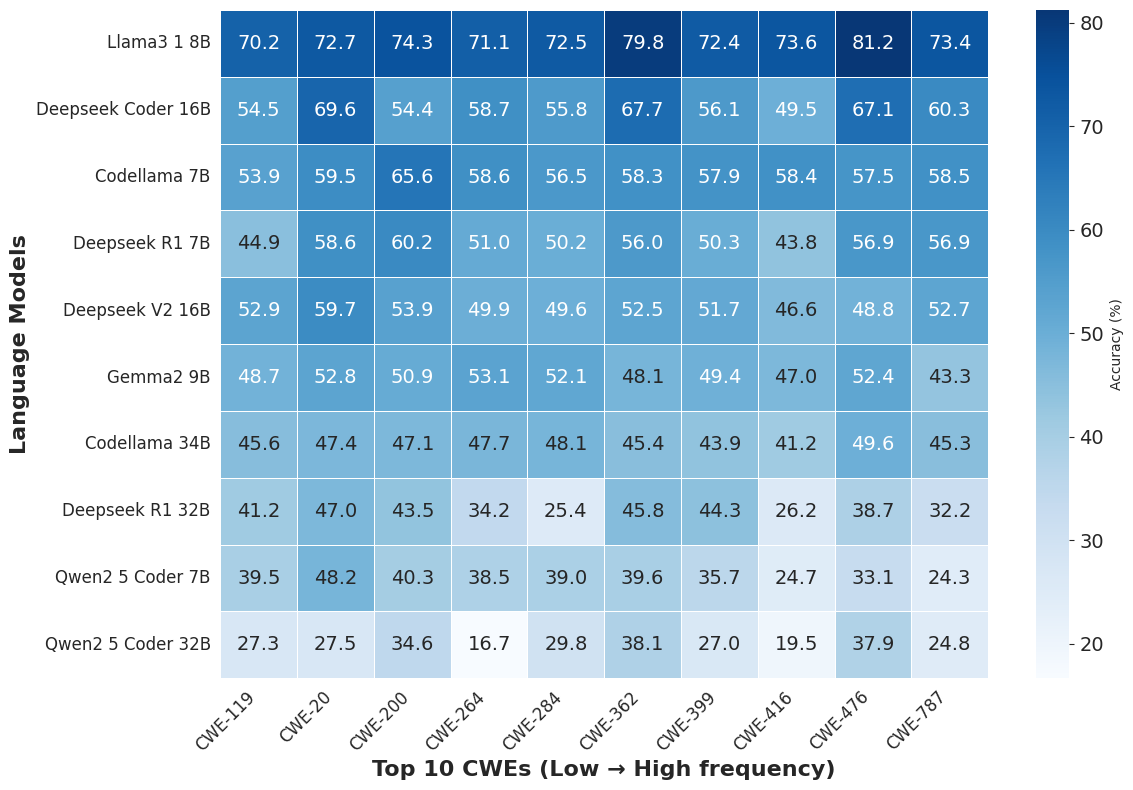

In [77]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to SQLite database
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# ----------------------------------------------------
# 1. Identify Top 10 Most Frequent CWEs
# ----------------------------------------------------
cwe_df = pd.read_sql_query(
    """
    SELECT VULNERABILITY_CWE
    FROM vulnerabilities
    WHERE VULNERABILITY_CWE IS NOT NULL
    """,
    conn
)

# Count occurrences of each CWE and get the top 10
top_cwes = cwe_df['VULNERABILITY_CWE'].value_counts().nlargest(10).index.tolist()

# ----------------------------------------------------
# 2. Define Model Tables and Accuracy Columns
# ----------------------------------------------------
model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

# Accuracy-related columns across all prompts
vuln_cols = ['BASELINE_VULN', 'COT_VULN', 'THINK_VULN', 'THINK_VERIFY_VULN']
patch_cols = ['BASELINE_PATCH', 'COT_PATCH', 'THINK_PATCH', 'THINK_VERIFY_PATCH']

# Function to process ambiguous values (2 -> 0.5, keep 0 and 1 as-is)
def map_ambiguous_to_half(x):
    try:
        x = float(x)
        if x == 2:
            return 0.5
        return x
    except:
        return None

# ----------------------------------------------------
# 3. Process Each Model and Compute Accuracy per CWE
# ----------------------------------------------------
all_models_list = []

for table_name in model_tables:
    try:
        # Read model-specific data with the correct CWE column name
        query = f"""
            SELECT 
                v.VULNERABILITY_CWE AS CWE,
                m.BASELINE_VULN, m.BASELINE_PATCH,
                m.COT_VULN, m.COT_PATCH,
                m.THINK_VULN, m.THINK_PATCH,
                m.THINK_VERIFY_VULN, m.THINK_VERIFY_PATCH
            FROM {table_name} AS m
            JOIN vulnerabilities AS v ON m.COMMIT_HASH = v.COMMIT_HASH
            WHERE v.VULNERABILITY_CWE IN ({','.join(['?'] * len(top_cwes))})
        """
        model_df = pd.read_sql_query(query, conn, params=top_cwes)
        
        if len(model_df) == 0:
            print(f"[WARNING] No valid data for {table_name}")
            continue
        
        # Convert ambiguous values in all relevant columns
        for col in vuln_cols + patch_cols:
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Compute overall accuracy across all prompts
        model_df['accuracy'] = model_df[vuln_cols + patch_cols].mean(axis=1) * 100
        
        # Aggregate mean accuracy per CWE
        cwe_accuracy = model_df.groupby('CWE')['accuracy'].mean().reset_index()
        
        # Add model name for identification
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        cwe_accuracy['model_name'] = model_name
        
        all_models_list.append(cwe_accuracy)
        
    except Exception as e:
        print(f"[ERROR] Problem processing {table_name}: {str(e)}")

# ----------------------------------------------------
# 4. Combine Data and Pivot for Heatmap
# ----------------------------------------------------
if not all_models_list:
    print("No valid data to plot.")
    conn.close()
    exit()

final_df = pd.concat(all_models_list, ignore_index=True).dropna()

# Pivot table for heatmap (models as rows, CWEs as columns)
heatmap_data = final_df.pivot(index='model_name', columns='CWE', values='accuracy')

# ----------------------------------------------------
# 4.1. Order the heatmap rows by overall average accuracy (ascending)
# ----------------------------------------------------
# Calculate overall average accuracy for each model across all CWEs
# model_order = heatmap_data.mean(axis=1).sort_values().index
model_order = heatmap_data.mean(axis=1).sort_values(ascending=False).index

# Reorder the pivot table rows accordingly
heatmap_data = heatmap_data.loc[model_order]

# ----------------------------------------------------
# 5. Plot Heatmap
# ----------------------------------------------------
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.heatmap(heatmap_data, annot=True, fmt=".1f",
            cmap="Blues",
            # vmin=0, vmax=100,  # if your data is 0–100
            center=50,        # center on 50%
            linewidths=0.5,
            annot_kws={"size": 14},
            cbar_kws={"label": "Accuracy (%)"})

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

plt.xlabel('Top 10 CWEs (Low → High frequency)', fontsize=16, weight='bold')
plt.ylabel('Language Models', fontsize=16, weight='bold')
# plt.title('LLM Performance on Top 10 Critical CWEs (Accuracy %)')
plt.xticks(rotation=45, ha='right', fontsize=12) # make the font bold
plt.yticks(rotation=-0, fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig('cwe_heatmap.png', dpi=300)
plt.show()

# Close database connection
conn.close()



/tmp/ipykernel_1061917/2767971042.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.94])


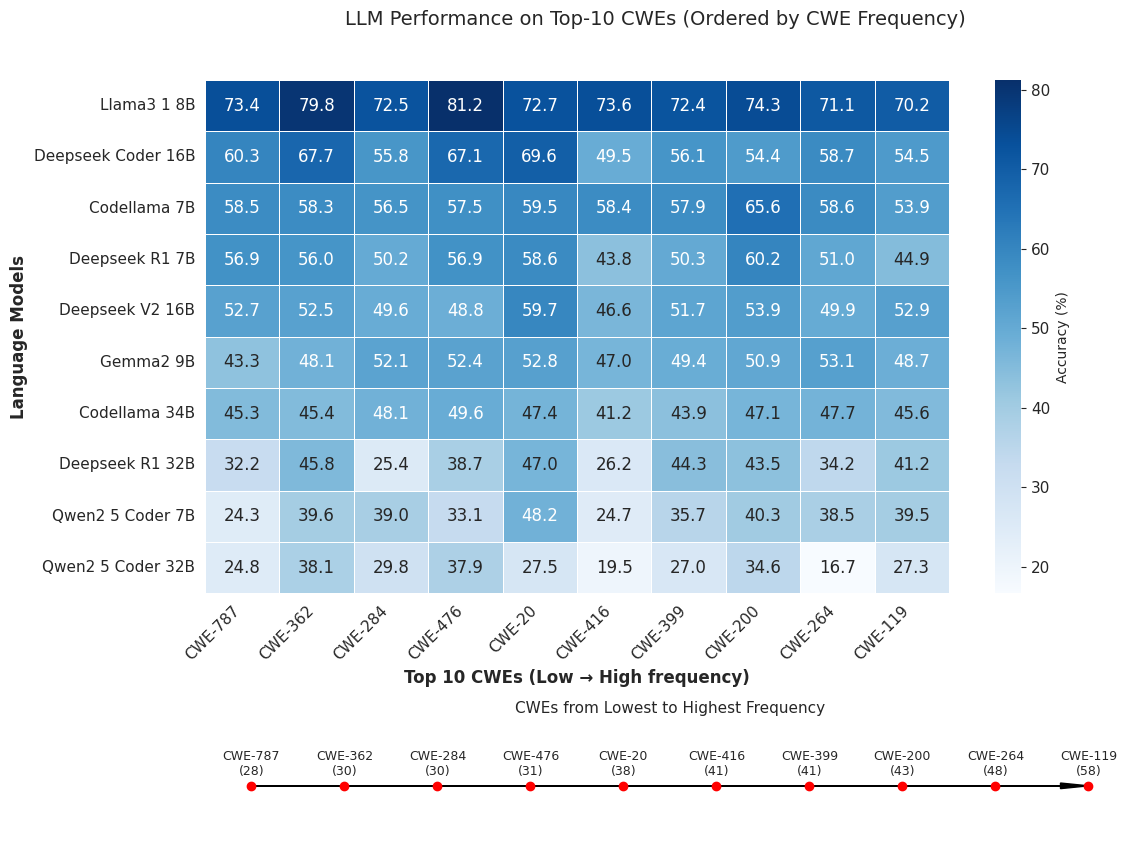

In [71]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Connect to DB and load all CWE data
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

cwe_df = pd.read_sql_query(
    """
    SELECT VULNERABILITY_CWE
    FROM vulnerabilities
    WHERE VULNERABILITY_CWE IS NOT NULL
    """,
    conn
)

# Count total occurrences of each CWE
cwe_counts = cwe_df['VULNERABILITY_CWE'].value_counts()

# Pick Top 10 (descending by frequency)
top10_cwes_desc = cwe_counts.nlargest(10)  # This is high→low

# Reorder them ascending by frequency (low→high)
top10_cwes_asc = top10_cwes_desc.sort_values(ascending=True)

# We'll store just the index list (CWE labels) in ascending order
top10_cwes = top10_cwes_asc.index.tolist()  # from low freq to high freq

# 2) Define model tables and prompt columns
model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

vuln_cols = ['BASELINE_VULN', 'COT_VULN', 'THINK_VULN', 'THINK_VERIFY_VULN']
patch_cols = ['BASELINE_PATCH', 'COT_PATCH', 'THINK_PATCH', 'THINK_VERIFY_PATCH']

def map_ambiguous_to_half(x):
    """Convert '2' → 0.5, otherwise keep numeric or None."""
    try:
        val = float(x)
        if val == 2:
            return 0.5
        return val
    except:
        return None

# 3) For each model, compute accuracy per CWE
all_models_list = []

for table_name in model_tables:
    query = f"""
        SELECT 
            v.VULNERABILITY_CWE AS CWE,
            m.BASELINE_VULN, m.BASELINE_PATCH,
            m.COT_VULN,      m.COT_PATCH,
            m.THINK_VULN,    m.THINK_PATCH,
            m.THINK_VERIFY_VULN, m.THINK_VERIFY_PATCH
        FROM {table_name} AS m
        JOIN vulnerabilities AS v 
            ON m.COMMIT_HASH = v.COMMIT_HASH
        WHERE v.VULNERABILITY_CWE IN ({','.join(['?'] * len(top10_cwes))})
    """
    try:
        model_df = pd.read_sql_query(query, conn, params=top10_cwes)
        if len(model_df) == 0:
            print(f"[WARNING] No valid data for {table_name}")
            continue
        
        # Convert ambiguous values in all relevant columns
        for col in vuln_cols + patch_cols:
            model_df[col] = pd.to_numeric(model_df[col], errors='coerce').apply(map_ambiguous_to_half)
        
        # Compute overall accuracy across all 8 prompts (4 vuln + 4 patch)
        model_df['accuracy'] = model_df[vuln_cols + patch_cols].mean(axis=1) * 100
        
        # Group mean accuracy by CWE
        cwe_accuracy = model_df.groupby('CWE')['accuracy'].mean().reset_index()
        
        # Add model name
        model_name = table_name.replace('vulnerabilities_', '').replace('_', ' ').title()
        cwe_accuracy['model_name'] = model_name
        
        all_models_list.append(cwe_accuracy)
        
    except Exception as e:
        print(f"[ERROR] {table_name}: {e}")

conn.close()

if not all_models_list:
    print("No valid data to plot.")
    exit()

final_df = pd.concat(all_models_list, ignore_index=True).dropna()

# 4) Pivot for heatmap => rows=Model, columns=CWE, values=Accuracy
heatmap_data = final_df.pivot(index='model_name', columns='CWE', values='accuracy')

# 5) Reorder the columns from low freq → high freq
#    based on our 'top10_cwes_asc' list
#    and also reorder rows if you want (e.g. by model name alpha or average accuracy).
#    For demonstration, let's just keep rows in descending average accuracy
heatmap_data = heatmap_data[top10_cwes]  # reorder columns

# row order => descending average accuracy across these 10 columns
model_order = heatmap_data.mean(axis=1).sort_values(ascending=False).index
heatmap_data = heatmap_data.loc[model_order]

# ------------------------------------------------------------
# 6) Plot: We'll make ONE figure with two subplots stacked:
#    (A) Heatmap on top
#    (B) Arrow diagram (CWE frequencies) on bottom
# ------------------------------------------------------------
fig = plt.figure(figsize=(12, 10))
# create a GridSpec with 2 rows, 1 column, height ratio => 4:1
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.4)

# Subplot 1 => Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.set_style("whitegrid")

# If you'd like to define a color range, uncomment vmin/vmax
# or the "center=50" if your data is in [0..100].
heatmap = sns.heatmap(
    heatmap_data,
    annot=True, fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    annot_kws={"size": 12},
    cbar_kws={"label": "Accuracy (%)"},
    ax=ax1
)
# config
ax1.set_xlabel('Top 10 CWEs (Low → High frequency)', fontsize=12, weight='bold')
ax1.set_ylabel('Language Models', fontsize=12, weight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=11)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)

# Subplot 2 => Horizontal arrow from left(low freq) to right(high freq)
ax2 = fig.add_subplot(gs[1, 0])
ax2.get_yaxis().set_visible(False)
# we only have 10 CWEs => positions 0..9
ax2.set_xlim(-0.5, 9.5)
ax2.set_ylim(-0.8, 0.8)  # minimal vertical space
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])

# Draw big arrow
ax2.arrow(
    0, 0, 9, 0,  # x=0 => x=9
    length_includes_head=True,
    head_width=0.07,
    head_length=0.3,
    fc='black', ec='black'
)

# cwe_counts has them in descending order, but we stored top10_cwes_asc for ascending
# We'll iterate over each cwe in ascending frequency order and mark them from 0..9
for i, cwe_label in enumerate(top10_cwes):
    freq = top10_cwes_asc[cwe_label]  # retrieve the frequency from the sorted Series
    # place a small circle at the arrow
    ax2.plot(i, 0, 'o', color='red')
    # text above or below
    ax2.text(
        i, 0.1,   # slightly above
        f"{cwe_label}\n({freq})",
        ha='center', va='bottom',
        fontsize=9
    )

ax2.set_title("CWEs from Lowest to Highest Frequency", fontsize=11)

plt.suptitle("LLM Performance on Top-10 CWEs (Ordered by CWE Frequency)", fontsize=14, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("cwe_heatmap_with_arrow.png", dpi=300)
plt.show()


## RQ3 abstraction levels

[WARNING] No data found in vulnerabilities_deepseek_r1_32b


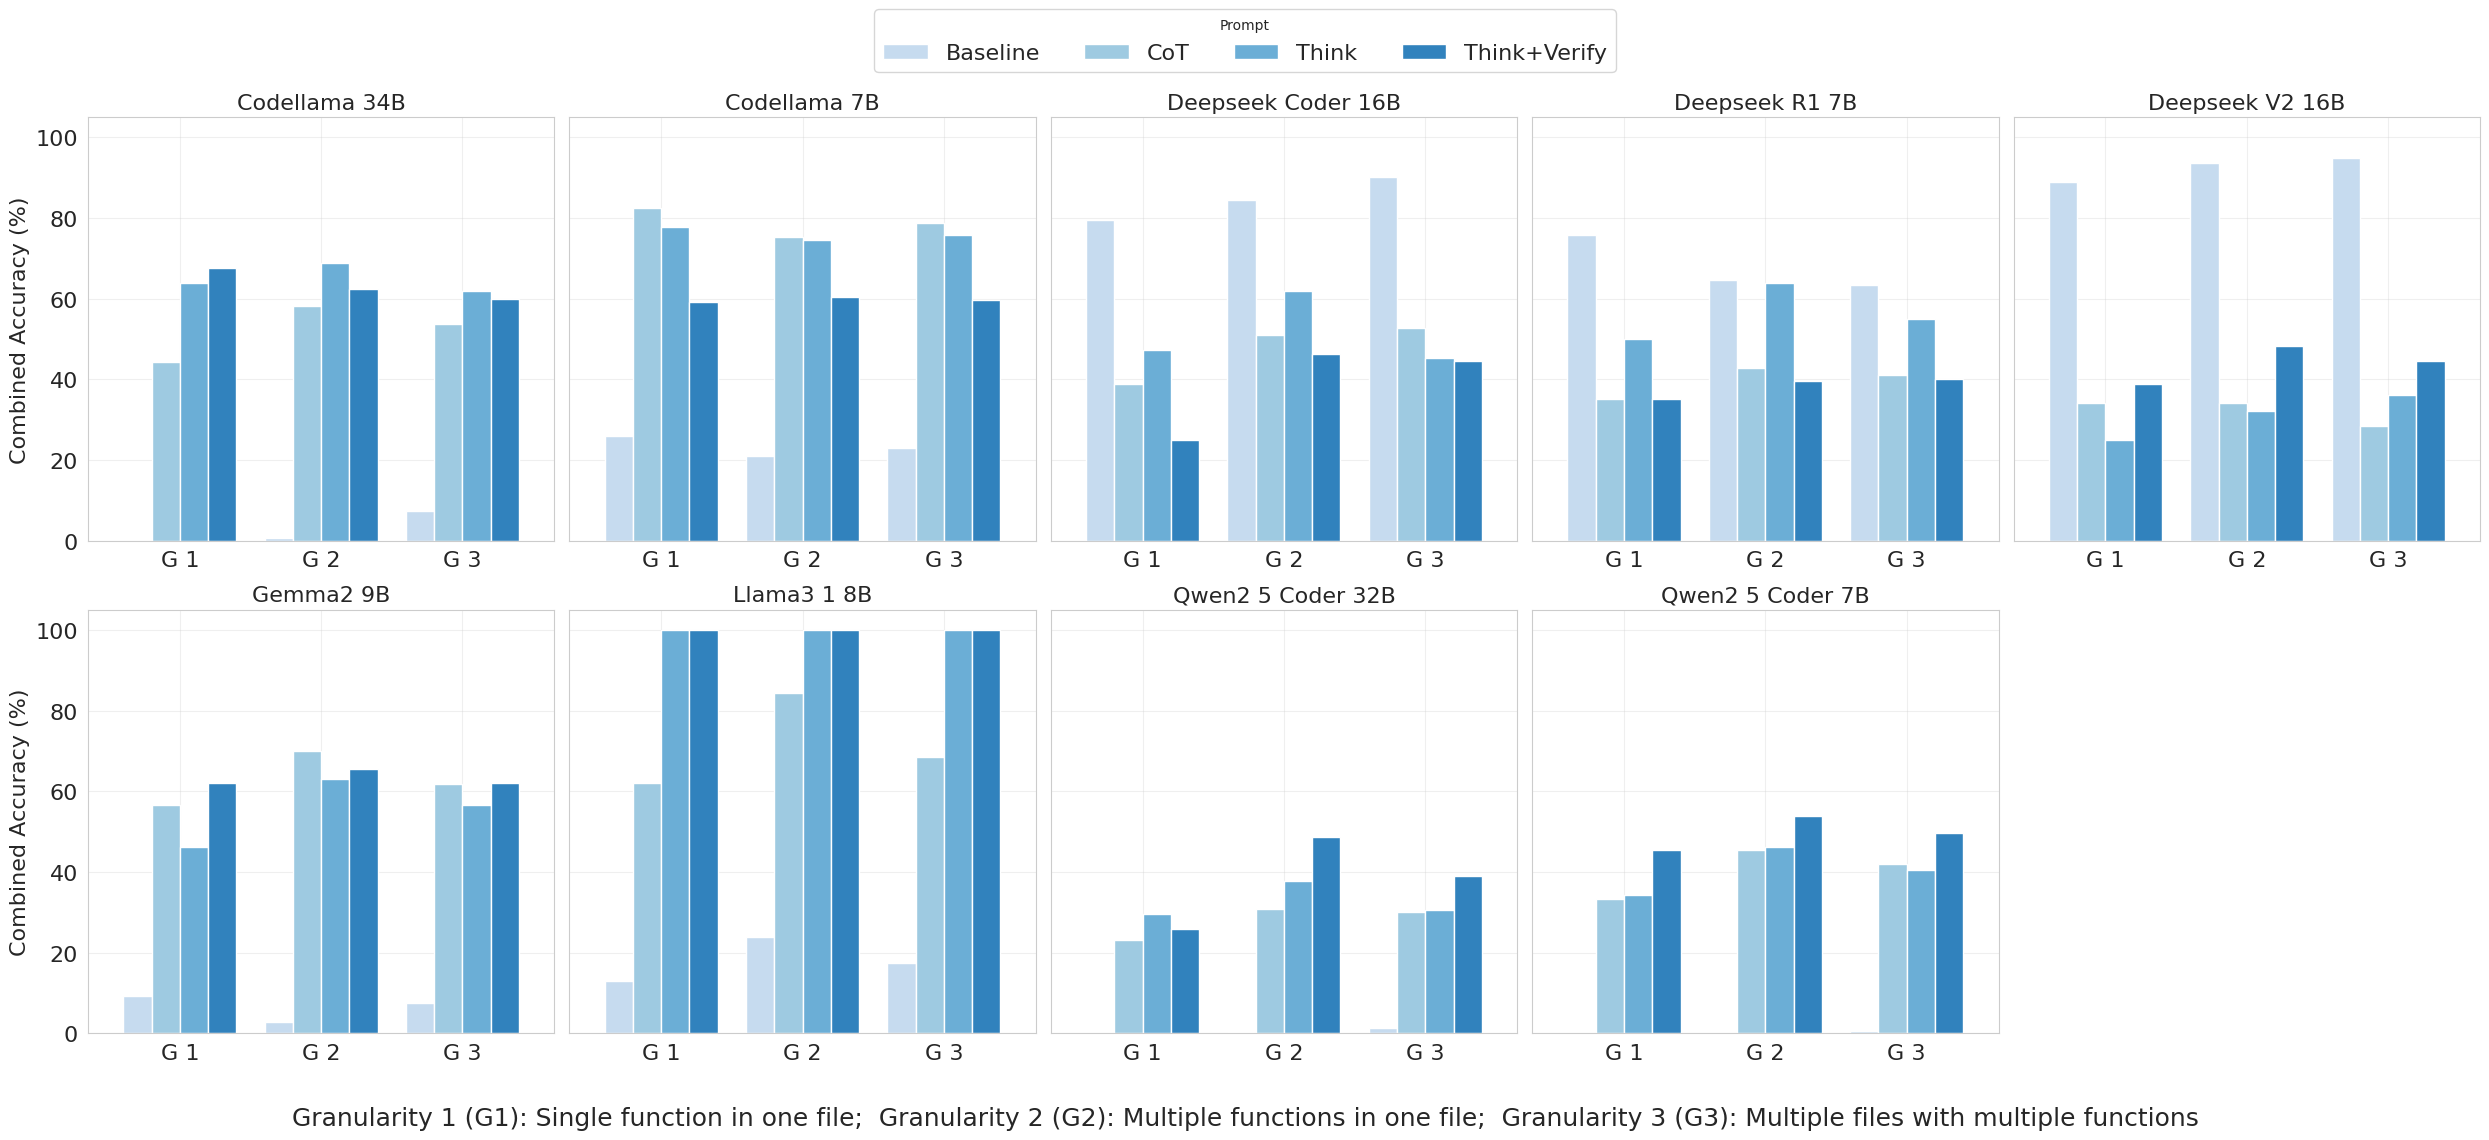

In [24]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# 1. Connect to DB and read (COMMIT_HASH, NUM_FILES_CHANGED, NUM_FUNCTIONS_CHANGED)
# ----------------------------------------------------------------
db_path = '/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/database.sqlite'
conn = sqlite3.connect(db_path)

vuln_df = pd.read_sql_query(
    """
    SELECT 
        COMMIT_HASH, 
        NUM_FILES_CHANGED, 
        NUM_FUNCTIONS_CHANGED
    FROM vulnerabilities
    WHERE NUM_FILES_CHANGED IS NOT NULL 
      AND NUM_FUNCTIONS_CHANGED IS NOT NULL
    """,
    conn
)

# Convert to numeric
vuln_df['NUM_FILES_CHANGED']    = pd.to_numeric(vuln_df['NUM_FILES_CHANGED'], errors='coerce')
vuln_df['NUM_FUNCTIONS_CHANGED'] = pd.to_numeric(vuln_df['NUM_FUNCTIONS_CHANGED'], errors='coerce')

# Define a helper to categorize abstraction based on #files / #functions
def classify_abstraction(row):
    if row['NUM_FILES_CHANGED'] == 1 and row['NUM_FUNCTIONS_CHANGED'] == 1:
        return "Single function in one file"
    elif row['NUM_FILES_CHANGED'] == 1 and row['NUM_FUNCTIONS_CHANGED'] > 1:
        return "Multiple functions in one file"
    else:
        return "Multiple files with multiple functions"

vuln_df['ABSTRACTION_LEVEL'] = vuln_df.apply(classify_abstraction, axis=1)

# (Optional) Map the original textual labels to simpler “Granularity” labels
abstraction_mapping = {
    "Single function in one file":         "Granularity 1",
    "Multiple functions in one file":      "Granularity 2",
    "Multiple files with multiple functions": "Granularity 3"
}
vuln_df['ABSTRACTION_LEVEL'] = vuln_df['ABSTRACTION_LEVEL'].map(abstraction_mapping)

conn.close()

# ----------------------------------------------------------------
# 2. Model tables and prompt columns
# ----------------------------------------------------------------
model_tables = [
    'vulnerabilities_deepseek_r1_7b',
    'vulnerabilities_llama3_1_8b',
    'vulnerabilities_gemma2_9b',
    'vulnerabilities_qwen2_5_coder_7b',
    'vulnerabilities_codellama_7b',
    'vulnerabilities_deepseek_r1_32b',
    'vulnerabilities_deepseek_v2_16b',
    'vulnerabilities_deepseek_coder_16b',
    'vulnerabilities_qwen2_5_coder_32b',
    'vulnerabilities_codellama_34b'
]

vuln_prompts = {
    'Baseline':     'BASELINE_VULN',
    'CoT':          'COT_VULN',
    'Think':        'THINK_VULN',
    'Think+Verify': 'THINK_VERIFY_VULN'
}
patch_prompts = {
    'Baseline':     'BASELINE_PATCH',
    'CoT':          'COT_PATCH',
    'Think':        'THINK_PATCH',
    'Think+Verify': 'THINK_VERIFY_PATCH'
}

# ----------------------------------------------------------------
# 3. Helper: "2" => 0.5 partial credit
# ----------------------------------------------------------------
def map_ambiguous_to_half(x):
    try:
        f = float(x)
        if f == 2:
            return 0.5
        return f
    except:
        return np.nan

# ----------------------------------------------------------------
# 4. Read each LLM table, compute combined accuracy
# ----------------------------------------------------------------
conn = sqlite3.connect(db_path)
all_models_list = []

for tbl in model_tables:
    query = f"""
        SELECT 
            m.COMMIT_HASH,
            m.BASELINE_VULN,   m.BASELINE_PATCH,
            m.COT_VULN,        m.COT_PATCH,
            m.THINK_VULN,      m.THINK_PATCH,
            m.THINK_VERIFY_VULN, m.THINK_VERIFY_PATCH
        FROM {tbl} AS m
        WHERE 
            BASELINE_VULN IS NOT NULL
            AND COT_VULN      IS NOT NULL
            AND THINK_VULN    IS NOT NULL
            AND THINK_VERIFY_VULN IS NOT NULL
    """
    df_model = pd.read_sql_query(query, conn)
    if df_model.empty:
        print(f"[WARNING] No data found in {tbl}")
        continue
    
    # Map "2" => 0.5 for relevant columns
    for col in list(vuln_prompts.values()) + list(patch_prompts.values()):
        df_model[col] = df_model[col].apply(map_ambiguous_to_half)
    
    # Merge with the abstraction data
    merged = pd.merge(
        df_model,
        vuln_df[['COMMIT_HASH','ABSTRACTION_LEVEL']],
        on='COMMIT_HASH',
        how='inner'
    )
    if merged.empty:
        print(f"[WARNING] After merge, no data for {tbl}")
        continue
    
    # Clean model name
    model_name = tbl.replace('vulnerabilities_', '').replace('_', ' ').title()
    merged['model_name'] = model_name
    
    # Reshape => (model_name, ABSTRACTION_LEVEL, prompt, combined_accuracy)
    # combined_accuracy = (vuln + patch)/2 => fraction in [0..1]
    records = []
    for prompt in vuln_prompts.keys():
        vuln_col  = vuln_prompts[prompt]
        patch_col = patch_prompts[prompt]
        
        combo = (merged[vuln_col] + merged[patch_col]) / 2.0
        for i in range(len(merged)):
            rec = {
                'model_name':        merged.loc[i, 'model_name'],
                'ABSTRACTION_LEVEL': merged.loc[i, 'ABSTRACTION_LEVEL'],
                'prompt':            prompt,
                'combined_accuracy': combo.iloc[i]
            }
            records.append(rec)
    
    all_models_list.extend(records)

conn.close()

final_df = pd.DataFrame(all_models_list).dropna(subset=['combined_accuracy'])
if final_df.empty:
    print("No valid rows remain after merging and cleaning.")
    exit()

# Convert to percentage
final_df['combined_accuracy'] *= 100.0

# ----------------------------------------------------------------
# 5. Group by (model_name, ABSTRACTION_LEVEL, prompt)
# ----------------------------------------------------------------
grouped = final_df.groupby(
    ['model_name','ABSTRACTION_LEVEL','prompt']
)['combined_accuracy'].mean().reset_index()

# Sort categories
abstraction_order = ["Granularity 1","Granularity 2","Granularity 3"]
grouped['ABSTRACTION_LEVEL'] = pd.Categorical(
    grouped['ABSTRACTION_LEVEL'], 
    categories=abstraction_order,
    ordered=True
)
prompt_order = ["Baseline","CoT","Think","Think+Verify"]
grouped['prompt'] = pd.Categorical(
    grouped['prompt'], 
    categories=prompt_order,
    ordered=True
)

# We'll rename them in the final plot as "G 1", "G 2", "G 3".
rename_map = {
    "Granularity 1": "G 1",
    "Granularity 2": "G 2",
    "Granularity 3": "G 3"
}

# ----------------------------------------------------------------
# 6. Plot: 10 subplots, each with x‐axis labeled "G 1","G 2","G 3" horizontally
# ----------------------------------------------------------------
unique_models = grouped['model_name'].unique()
n_models = len(unique_models)

fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharey=True)
axes = axes.ravel()

# Define custom pastel color palette for the 4 prompts
prompt_colors = ["#c6dbef", "#9ecae1", "#6baed6", "#3182bd"]

for i, model_name in enumerate(unique_models):
    ax = axes[i]
    sub = grouped[grouped['model_name'] == model_name]
    
    # Pivot => rows=Granularity, cols=Prompt, values=Mean Accuracy
    pivoted = sub.pivot(index='ABSTRACTION_LEVEL', columns='prompt', values='combined_accuracy')
    
    # Before plotting, rename the index to "G 1"/"G 2"/"G 3"
    pivoted = pivoted.rename(index=rename_map)
    
    # The grouped bar chart
    pivoted.plot(
        kind='bar',
        ax=ax,
        width=0.8,
        legend=False,
        color=prompt_colors
    )
    
    # (1) Increase font sizes by 2:
    ax.set_title(model_name, fontsize=16)              # was 12
    ax.set_xlabel("", fontsize=13)                     # was 11
    ax.set_ylabel("Combined Accuracy (%)", fontsize=16)  # default +2
    ax.tick_params(axis='x', labelrotation=0, labelsize=16)  # horizontal G 1,2,3 + bigger font
    ax.tick_params(axis='y', labelsize=16)             # bigger y‐tick labels
    
    ax.set_ylim(0, 105)
    ax.grid(alpha=0.3)

# Hide extra subplots if < 10
if n_models < 10:
    for j in range(n_models, 10):
        fig.delaxes(axes[j])

# Global legend: bigger font size
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5,1.08),
    ncol=4,
    title="Prompt",
    fontsize=16  
)

# Increase bottom note font from 14 to 16
fig.text(
    0.5, 
    -0.04, 
    "Granularity 1 (G1): Single function in one file;  Granularity 2 (G2): Multiple functions in one file;  Granularity 3 (G3): Multiple files with multiple functions", 
    ha="center", 
    va="center", 
    fontsize=18
)

plt.tight_layout()
plt.savefig("granularity.png", dpi=300)
plt.show()


In [ ]:
import sqlite3

def add_columns_to_database(db_path, table_name):
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # List of new columns to add
        new_columns = [
            ("VULNERABILITY_YEAR", "INTEGER"),
            ("VULNERABILITY_CATEGORY", "TEXT"),
            ("DESCRIPTION_IN_PATCH", "TEXT")
        ]

        # Add each column if it does not already exist
        for column, data_type in new_columns:
            try:
                cursor.execute(f"""
                    ALTER TABLE {table_name} ADD COLUMN {column} {data_type}
                """)
            except sqlite3.OperationalError:
                print(f"Column {column} might already exist in {table_name}.")

        # Commit changes and close connection
        conn.commit()
        print("Columns added successfully.")
    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
    finally:
        conn.close()

# Usage example
if __name__ == "__main__":
    database_path = "/users/azibaeir/Research/Benchmarking/project/vulnerability_dataset/database/2025_database.sqlite"  # Path to your SQLite database
    table_name = "vulnerabilities"  # Replace with your actual table name
    add_columns_to_database(database_path, table_name)
